# Auto-Pilot Tensorflow

In [1]:
import cv2
import random
import numpy as np

In [2]:
xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
test_batch_pointer = 0


# Read data.txt

In [3]:
with open("C:/Users/asus/Desktop/07012018/data.txt") as f:
    for line in f:
        xs.append("C:/Users/asus/Desktop/07012018/Data/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.strip().split()[1].split(',')[0]))#shuffle list of images
ys = np.array(ys)


In [4]:
#get number of images
num_images = len(xs)
num_images

63825

In [5]:
img = cv2.imread("C:/Users/asus/Desktop/07012018/Data/0.jpg")
img.shape

(256, 455, 3)

In [6]:
#shuffle list of images
c = list(zip(xs, ys))
random.shuffle(c)
xs, ys = zip(*c)

In [7]:
train_xs = xs[:int(len(xs) * 0.8)]
train_ys = ys[:int(len(xs) * 0.8)]

test_xs = xs[-int(len(xs) * 0.2):]
test_ys = ys[-int(len(xs) * 0.2):]


In [8]:
num_train_images = len(train_xs)
num_val_images = len(test_xs)
print(num_train_images)
print(num_val_images)

51060
12765


# PDF of train and test 'y' values.

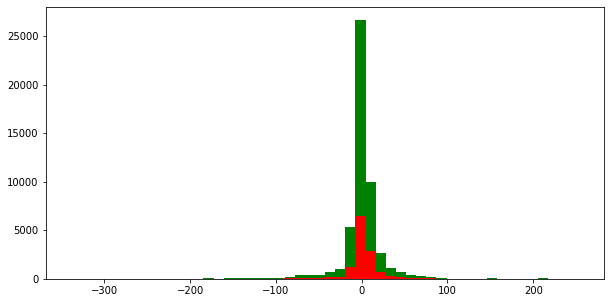

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist(train_ys,bins=50,color='green',)
plt.hist(test_ys,bins=50,color='red')
plt.show()

# Model : 0 Baseline model

In [11]:
train_mean_y = np.mean(train_ys)

print('Test_MSE(MEAN):%f' %np.mean(np.square(test_ys - train_mean_y)))

print('Test_MSE(ZERO):%f' %np.mean(np.square(test_ys - 0.0)))

Test_MSE(MEAN):653.248414


TypeError: unsupported operand type(s) for -: 'tuple' and 'float'

In [12]:
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_train = []
    y_train = []
    for i in range(0, batch_size):
        x_train.append(cv2.resize(cv2.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], (200, 66)) / 255.0)
        y_train.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_train, y_train

In [22]:
x_train,y_train = LoadTrainBatch(100)

In [15]:
def LoadTestBatch(batch_size):
    global test_batch_pointer
    x_test = []
    y_test = []
    for i in range(0, batch_size):
        x_test.append(cv2.resize(cv2.imread(test_xs[(test_batch_pointer + i) % num_val_images])[-150:], (200, 66)) / 255.0)
        y_test.append([test_ys[(test_batch_pointer + i) % num_val_images]])
    test_batch_pointer += batch_size
    return x_test, y_test

In [25]:
x_test,y_test = LoadTestBatch(100)

In [60]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import scipy

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output


In [65]:
import os
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(num_images/batch_size)):
    xs, ys = LoadTrainBatch(batch_size)
    train_step.run(feed_dict={x: xs, y_: ys, keep_prob: 0.8})
    if i % 10 == 0:
      xs, ys = LoadTestBatch(batch_size)
      loss_value = loss.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    #summary = merged_summary_op.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
    #summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


Epoch: 0, Step: 0, Loss: 798.747
Epoch: 0, Step: 10, Loss: 466.322
Epoch: 0, Step: 20, Loss: 449.016
Epoch: 0, Step: 30, Loss: 630.29
Epoch: 0, Step: 40, Loss: 632.223
Epoch: 0, Step: 50, Loss: 794.853
Epoch: 0, Step: 60, Loss: 747.707
Epoch: 0, Step: 70, Loss: 460.442
Epoch: 0, Step: 80, Loss: 655.412
Epoch: 0, Step: 90, Loss: 285.955
Epoch: 0, Step: 100, Loss: 525.063
Epoch: 0, Step: 110, Loss: 687.848
Epoch: 0, Step: 120, Loss: 568.75
Epoch: 0, Step: 130, Loss: 465.758
Epoch: 0, Step: 140, Loss: 543.581


KeyboardInterrupt: 

In [19]:
from tensorflow.keras import utils 
import seaborn as sns
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout ,BatchNormalization,Conv3D

In [56]:
input_shape = (100,66,200,3)

model = Sequential()

model.add(Conv3D(24,(5,5,3),activation='relu',input_shape=input_shape,padding='valid'))
          
model.add(Conv3D(36,(5,5,24),activation='relu',padding='Valid'))
          
model.add(Conv3D(48,(5,5,36),activation='relu',padding='Valid'))
          
model.add(Conv3D(64,(5,5,48),activation='relu',padding='Valid'))

model.add(Conv3D(64,(5,5,64),activation='relu',padding='Valid'))
          
model.add(Dense(1152,activation='relu'))

model.add(Dropout(0.2))
          
model.add(Dense(1164,activation='relu'))

model.add(Dropout(0.2))
          
model.add(Dense(100,activation='relu'))

model.add(Dropout(0.2))
          
model.add(Dense(50,activation='relu'))

model.add(Dropout(0.2))
          
model.add(Dense(10,activation='relu'))

model.add(Dropout(0.2))
          
model.add(Dense(1,activation='tanh'))


In [57]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 96, 62, 198, 24)   5424      
                                                                 
 conv3d_22 (Conv3D)          (None, 92, 58, 175, 36)   518436    
                                                                 
 conv3d_23 (Conv3D)          (None, 88, 54, 140, 48)   1555248   
                                                                 
 conv3d_24 (Conv3D)          (None, 84, 50, 93, 64)    3686464   
                                                                 
 conv3d_25 (Conv3D)          (None, 80, 46, 30, 64)    6553664   
                                                                 
 dense_24 (Dense)            (None, 80, 46, 30, 1152)  74880     
                                                                 
 dropout_15 (Dropout)        (None, 80, 46, 30, 1152) 

In [59]:
model.compile(optimizer='adam',loss='scalar_loss',metrics=['SparseCategoricalAccuracy'])

ValueError: Unknown loss function: scalar_loss. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test),verbose=1,Bat)

In [39]:
x_train[0].shape

(66, 200, 3)

In [40]:
y_train[0]

[11.8]